<center><h1>Machine Learning: Identification of Frost in Martian HiRISE IMAGES </h1></center>

Name: Chengyi Li
<br>
Github Username: ChengyiLi98
<br>


In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

import random
import tensorflow as tf
from PIL import Image 

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [299,299])
        # normalize the image
        img = img / 255.0
        
        # convert label to integer
        label =1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    # Wrap the Python function   
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape((299, 299, 3)) 
    y.set_shape([]) 
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

## (c)Training CNN + MLP

### (i) Image augmentation for training set

In [5]:
import tensorflow_addons as tfa

def random_zoom(image):
    image_shape = tf.shape(image)
    image_height, image_width = image_shape[0], image_shape[1]

    # Set zoom factor
    zoom_factor = random.uniform(0.8, 1.2) # Zooming by 0.8 to 1.2x 

    # Calculate new height and width after zoom
    new_height = tf.cast(tf.cast(image_height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(image_width, tf.float32) * zoom_factor, tf.int32)

    # Perform zoom on the image
    zoomed_image = tf.image.resize(image, (new_height, new_width))

    # Pad or crop to the original size if necessary
    zoomed_image = tf.image.resize_with_crop_or_pad(zoomed_image, image_height, image_width)

    return zoomed_image

def random_translate(image):
    image_shape = tf.shape(image)
    image_height, image_width = image_shape[0], image_shape[1]

    # Define maximum translation in x and y directions
    max_dx = 50
    max_dy = 50
    # Calculate random translation shifts
    dx = tf.random.uniform([], -max_dx, max_dx)
    dy = tf.random.uniform([], -max_dy, max_dy)
    # Define translation matrix
    translation_matrix = tf.convert_to_tensor([[1.0, 0.0, dx], [0.0, 1.0, dy]])
    # Apply translation to the image
    translated_image = tf.image.transform(image, translation_matrix, interpolation='nearest')

    return translated_image

# Define augmentation functions
def augment_images(image, label):
    # Randomly select augmentation techniques
    augmentations = [
        lambda x: tf.image.random_flip_left_right(x),
        lambda x: tf.image.random_flip_up_down(x),
        lambda x: tf.image.random_contrast(x, lower=0.5, upper=1.5),
        lambda x: tf.image.random_brightness(x, max_delta=0.2),
        lambda x: tf.image.random_saturation(x, lower=0.5, upper=1.5),
        lambda x: tf.image.rot90(x, k=random.randint(1, 3)),  # Rotation by 90, 180, or 270 degrees
        lambda x: tf.image.random_crop(x, size=[32, 250, 250, 3]),  # Random crop to (250, 250)
        lambda x: tfa.image.translate(x, translations=[random.randint(-50, 50), random.randint(-50, 50)]),
        lambda x: random_zoom(x)
    ]
    # Randomly apply selected augmentations
    num_augmentations = random.randint(0, len(augmentations))  # Randomly choose 0 or more augmentations
    for i in range(num_augmentations):
        aug = random.choice(augmentations)
        image = aug(image)

    return image, label

# Apply augmentation to the dataset
tf_dataset_train_aug = tf_dataset_train.map(augment_images)

### (ii)Train a three-layer CNN followed by a dense layer on the data. &  iii. Report Precision, Recall, and F1 score for your model.

In [24]:
# parameters for Conv2D: filters, kernel_size =(,), 
# for Dense : units
# for max_pooling : pool_size
def my_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='sigmoid')  #binary classification (frost/background)
    ])
    return model

input_shape = (299, 299, 3) 
model_cnn = my_cnn_model(input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

# Compile model with adam optimizer and a learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(tf_dataset_train_aug, 
                    epochs=25, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/25
928/928 [==============================] - 939s 1s/step - loss: 4.4329 - accuracy: 0.7613 - val_loss: 2.3634 - val_accuracy: 0.9312
Epoch 2/25
928/928 [==============================] - 938s 1s/step - loss: 1.9099 - accuracy: 0.8355 - val_loss: 1.7519 - val_accuracy: 0.8883
Epoch 3/25
928/928 [==============================] - 941s 1s/step - loss: 1.3099 - accuracy: 0.8678 - val_loss: 1.2728 - val_accuracy: 0.9065
Epoch 4/25
928/928 [==============================] - 932s 1s/step - loss: 1.0178 - accuracy: 0.9037 - val_loss: 0.9340 - val_accuracy: 0.9015
Epoch 5/25
928/928 [==============================] - 933s 1s/step - loss: 0.9445 - accuracy: 0.9190 - val_loss: 0.8695 - val_accuracy: 0.9567
Epoch 6/25
928/928 [==============================] - 944s 1s/step - loss: 0.7564 - accuracy: 0.9460 - val_loss: 0.6488 - val_accuracy: 0.9647
Epoch 7/25
928/928 [==============================] - 954s 1s/step - loss: 0.7484 - accuracy: 0.9398 - val_loss: 0.5524 - val_accuracy: 0.9800

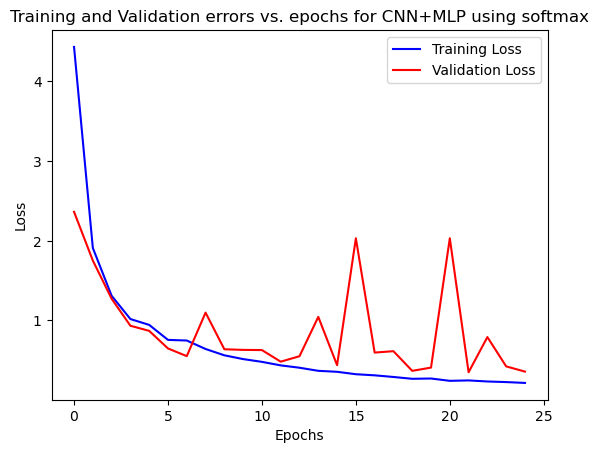

In [67]:
# Plotting training and validation errors vs. epochs
plt.plot(history_cnn.history['loss'], label='Training Loss', color = 'blue')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation errors vs. epochs for CNN+MLP using sigmoid')
plt.legend()
plt.show()   

In [17]:
model_cnn = load_model('best_model_cnn.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_cnn.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_cnnsig_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_cnn.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_cnnsig_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_cnn.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_cnnsig_test = classification_report(true_test_labels, predicted_labels)   

In [20]:
print(f'For train set of CNN+MLP using sigmoid: \n {cr_cnnsig_train}')
print(f'For val set of CNN+MLP using sigmoid: \n {cr_cnnsig_val}')    
print(f'For test set of CNN+MLP using sigmoid: \n {cr_cnnsig_test}') 

For train set of CNN+MLP using sigmoid: 
               precision    recall  f1-score   support

           0       0.59      0.86      0.70     12235
           1       0.86      0.58      0.69     17444

    accuracy                           0.70     29679
   macro avg       0.72      0.72      0.70     29679
weighted avg       0.75      0.70      0.69     29679

For val set of CNN+MLP using sigmoid: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7654
           1       0.92      0.84      0.88      3632

    accuracy                           0.93     11286
   macro avg       0.93      0.90      0.91     11286
weighted avg       0.93      0.93      0.93     11286

For test set of CNN+MLP using sigmoid: 
               precision    recall  f1-score   support

           0       0.61      1.00      0.76      4418
           1       1.00      0.67      0.80      8405

    accuracy                           0.78     12823
   ma

In [10]:
def my_cnn_model_new(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')  #binary classification (frost/background)
    ])
    return model

input_shape = (299, 299, 3) 
model_new = my_cnn_model_new(input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_new.h5', monitor='val_loss', save_best_only=True)

# Compile model with adam optimizer and a learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_new.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_new.fit(tf_dataset_train_aug, 
                    epochs=25, 
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])
# use this one 

00:28:05 | WARNING | module_wrapper  | From C:\Users\cheng\anaconda3\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



00:28:05 | WARNING | module_wrapper  | From C:\Users\cheng\anaconda3\Lib\site-packages\keras\src\layers\pooling\max_pooling2d.py:161: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Epoch 1/25



00:28:05 | WARNING | module_wrapper  | From C:\Users\cheng\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



00:28:06 | WARNING | module_wrapper  | From C:\Users\cheng\anaconda3\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



928/928 [==============================] - 976s 1s/step - loss: 45.3029 - accuracy: 0.5619 - val_loss: 75.7957 - val_accuracy: 0.3231
Epoch 2/25
928/928 [==============================] - 935s 1s/step - loss: 13.1464 - accuracy: 0.5701 - val_loss: 64.0023 - val_accuracy: 0.3218
Epoch 3/25
928/928 [==============================] - 932s 1s/step - loss: 2.4470 - accuracy: 0.5788 - val_loss: 1.6782 - val_accuracy: 0.3218
Epoch 4/25
928/928 [==============================] - 935s 1s/step - loss: 1.5136 - accuracy: 0.5855 - val_loss: 0.9037 - val_accuracy: 0.3218
Epoch 5/25
928/928 [==============================] - 933s 1s/step - loss: 0.7723 - accuracy: 0.5878 - val_loss: 0.8029 - val_accuracy: 0.3218
Epoch 6/25
928/928 [==============================] - 936s 1s/step - loss: 0.6950 - accuracy: 0.5878 - val_loss: 0.7799 - val_accuracy: 0.3218
Epoch 7/25
928/928 [==============================] - 943s 1s/step - loss: 0.6826 - accuracy: 0.5878 - val_loss: 0.7723 - val_accuracy: 0.3218
Epoch 

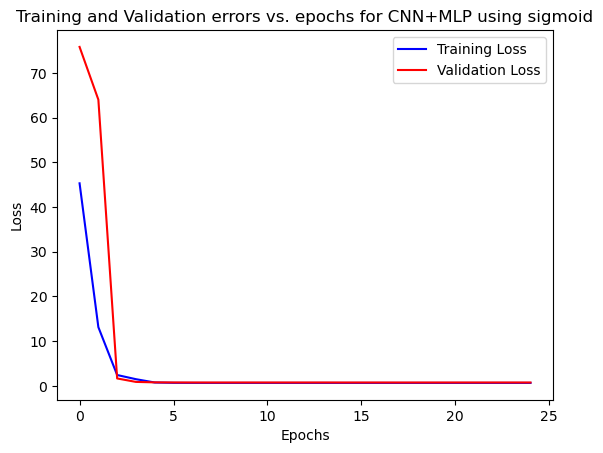

In [68]:
# Plotting training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss', color = 'blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'red')
plt.title('Training and Validation errors vs. epochs for CNN+MLP using softmax')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()   

In [24]:
model_new = load_model('best_model_new.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_new.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_cnnsft_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_new.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_cnnsft_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_new.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_cnnsft_test = classification_report(true_test_labels, predicted_labels)  

In [26]:
print(f'For train set of CNN+MLP using softmax: \n {cr_cnnsft_train}')
print(f'For val set of CNN+MLP using softmax: \n {cr_cnnsft_val}')    
print(f'For test set of CNN+MLP using softmax: \n {cr_cnnsft_test}') 

For train set of CNN+MLP using softmax: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     12235
           1       0.59      1.00      0.74     17444

    accuracy                           0.59     29679
   macro avg       0.29      0.50      0.37     29679
weighted avg       0.35      0.59      0.44     29679

For val set of CNN+MLP using softmax: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7654
           1       0.32      1.00      0.49      3632

    accuracy                           0.32     11286
   macro avg       0.16      0.50      0.24     11286
weighted avg       0.10      0.32      0.16     11286

For test set of CNN+MLP using softmax: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
   ma

## (d) Transfer Learning

### i.

In [5]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras import layers, Model

### ii.

Already done the image augmentation in (c), so that will use tf_dataset_train_aug in the following parts.

### iii. & iv. & v.

In [31]:
# Load the pre-trained model without top (classification) layers
base_model_eff = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model_eff.trainable = False

# Add new classification layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model_eff.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(2, activation='sigmoid')(x) 

# Create the final model
model_eff = models.Model(inputs=base_model_eff.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_eff.h5', monitor='val_loss', save_best_only=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_eff.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_eff = model_eff.fit(tf_dataset_train_aug, epochs=20, 
                            validation_data=tf_dataset_val, batch_size =5, 
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - 870s 935ms/step - loss: 0.7478 - accuracy: 0.5516 - val_loss: 0.7484 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 881s 949ms/step - loss: 0.6814 - accuracy: 0.5783 - val_loss: 0.7343 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 886s 955ms/step - loss: 0.6782 - accuracy: 0.5849 - val_loss: 0.7463 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 875s 943ms/step - loss: 0.6775 - accuracy: 0.5858 - val_loss: 0.7507 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 873s 941ms/step - loss: 0.6768 - accuracy: 0.5842 - val_loss: 0.7584 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 880s 948ms/step - loss: 0.6762 - accuracy: 0.5862 - val_loss: 0.7589 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 870s 938ms/step - loss: 0.6762 - accuracy: 0.5851 - val_loss: 0.7694 -

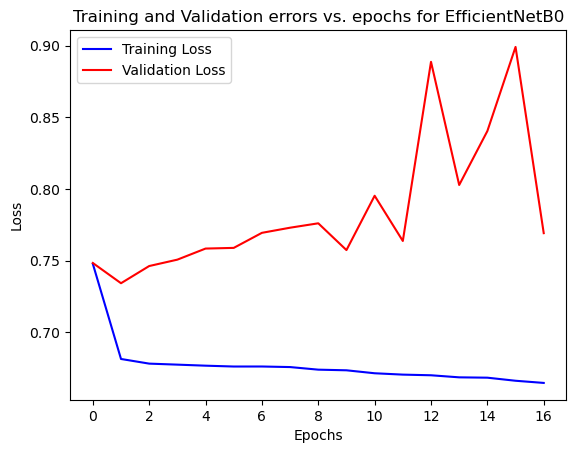

In [32]:
# Plot the training and validation errors vs. epochs.
plt.plot(history_eff.history['loss'], label='Training Loss', color='blue')
plt.plot(history_eff.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation errors vs. epochs for EfficientNetB0 using sigmoid')
plt.legend()
plt.show()

In [21]:
model_eff = load_model('best_model_eff.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_eff.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_effsig_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_eff.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_effsig_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_eff.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_effsig_test = classification_report(true_test_labels, predicted_labels)   

In [23]:
print(f'For train set of EfficientNetB0 using sigmoid: \n {cr_effsig_train}')
print(f'For val set of EfficientNetB0 using sigmoid: \n {cr_effsig_val}')    
print(f'For test set of EfficientNetB0 using sigmoid: \n {cr_effsig_test}') 

For train set of EfficientNetB0 using sigmoid: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     12235
           1       0.59      1.00      0.74     17444

    accuracy                           0.59     29679
   macro avg       0.29      0.50      0.37     29679
weighted avg       0.35      0.59      0.44     29679

For val set of EfficientNetB0 using sigmoid: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7654
           1       0.32      1.00      0.49      3632

    accuracy                           0.32     11286
   macro avg       0.16      0.50      0.24     11286
weighted avg       0.10      0.32      0.16     11286

For test set of EfficientNetB0 using sigmoid: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                          

In [94]:
# Load the pre-trained model without top (classification) layers
base_model_eff_1 = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
#base_model_eff_1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers in the base model
base_model_eff_1.trainable = False

# Add new classification layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model_eff_1.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x) 

# Create the final model
model_eff_1 = models.Model(inputs=base_model_eff_1.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_eff_1.h5', monitor='val_loss', save_best_only=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_eff_1.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_eff_1 = model_eff_1.fit(tf_dataset_train_aug, epochs=20, 
                            validation_data=tf_dataset_val, batch_size =8, 
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - 903s 970ms/step - loss: 0.7279 - accuracy: 0.5552 - val_loss: 0.7665 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 913s 983ms/step - loss: 0.6816 - accuracy: 0.5768 - val_loss: 0.7271 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 911s 982ms/step - loss: 0.6776 - accuracy: 0.5858 - val_loss: 0.7655 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 921s 992ms/step - loss: 0.6775 - accuracy: 0.5854 - val_loss: 0.7579 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 916s 987ms/step - loss: 0.6766 - accuracy: 0.5857 - val_loss: 0.7844 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 900s 970ms/step - loss: 0.6762 - accuracy: 0.5849 - val_loss: 0.7576 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 903s 973ms/step - loss: 0.6748 - accuracy: 0.5859 - val_loss: 0.7725 -

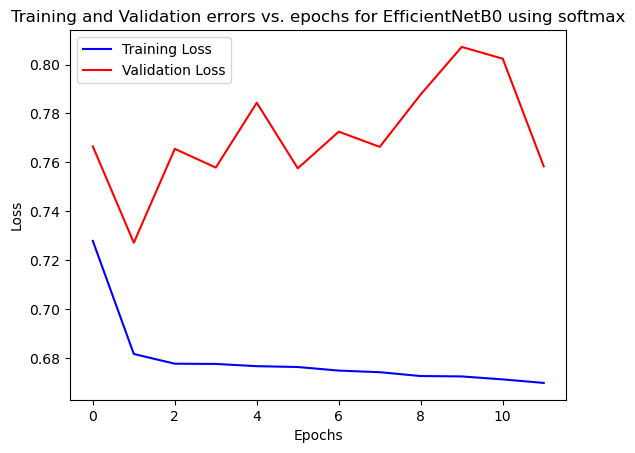

In [95]:
# Plot the training and validation errors vs. epochs.
plt.plot(history_eff_1.history['loss'], label='Training Loss', color='blue')
plt.plot(history_eff_1.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation errors vs. epochs for EfficientNetB0 using softmax')
plt.legend()
plt.show()

In [27]:
model_eff_1 = load_model('best_model_eff_1.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_eff_1.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_effsft_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_eff_1.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_effsft_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_eff_1.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_effsft_test = classification_report(true_test_labels, predicted_labels)   

In [29]:
print(f'For train set of EfficientNetB0 using softmax: \n {cr_effsft_train}')
print(f'For val set of EfficientNetB0 using softmax: \n {cr_effsft_val}')    
print(f'For test set of EfficientNetB0 using softmax: \n {cr_effsft_test}') 

For train set of EfficientNetB0 using softmax: 
               precision    recall  f1-score   support

           0       0.34      0.27      0.30     12235
           1       0.55      0.63      0.59     17444

    accuracy                           0.48     29679
   macro avg       0.44      0.45      0.44     29679
weighted avg       0.46      0.48      0.47     29679

For val set of EfficientNetB0 using softmax: 
               precision    recall  f1-score   support

           0       0.22      0.05      0.08      7654
           1       0.24      0.65      0.35      3632

    accuracy                           0.24     11286
   macro avg       0.23      0.35      0.21     11286
weighted avg       0.22      0.24      0.17     11286

For test set of EfficientNetB0 using softmax: 
               precision    recall  f1-score   support

           0       0.07      0.05      0.06      4418
           1       0.57      0.67      0.62      8405

    accuracy                          

In [70]:
base_model_res = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# Freeze all layers in the base model
base_model_res.trainable = False 

# Add new classification layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model_res.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x) # dense hidden layer
output = layers.Dense(2, activation='sigmoid')(x)

# Create the final model
model_res = models.Model(inputs=base_model_res.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_res.h5', monitor='val_loss', save_best_only=True)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_res.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_res = model_res.fit(tf_dataset_train_aug, epochs=20,
                            validation_data=tf_dataset_val, batch_size=8,
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - 1451s 2s/step - loss: 0.4647 - accuracy: 0.7803 - val_loss: 1.4825 - val_accuracy: 0.3640
Epoch 2/20
928/928 [==============================] - 1439s 2s/step - loss: 0.3873 - accuracy: 0.8236 - val_loss: 1.8709 - val_accuracy: 0.3758
Epoch 3/20
928/928 [==============================] - 1417s 2s/step - loss: 0.3649 - accuracy: 0.8356 - val_loss: 1.8764 - val_accuracy: 0.3905
Epoch 4/20
928/928 [==============================] - 1418s 2s/step - loss: 0.3394 - accuracy: 0.8506 - val_loss: 1.4219 - val_accuracy: 0.4771
Epoch 5/20
928/928 [==============================] - 1416s 2s/step - loss: 0.3277 - accuracy: 0.8539 - val_loss: 2.1361 - val_accuracy: 0.3471
Epoch 6/20
928/928 [==============================] - 1421s 2s/step - loss: 0.3170 - accuracy: 0.8623 - val_loss: 1.2168 - val_accuracy: 0.5380
Epoch 7/20
928/928 [==============================] - 1417s 2s/step - loss: 0.3048 - accuracy: 0.8680 - val_loss: 0.7868 - val_accuracy:

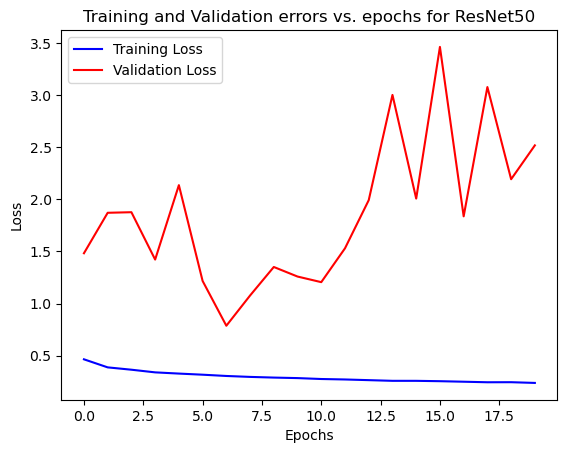

In [71]:
# Plot the training and validation errors vs. epochs.
plt.plot(history_res.history['loss'], label='Training Loss', color='blue')
plt.plot(history_res.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation errors vs. epochs for ResNet50')
plt.legend()
plt.show()

In [12]:
model_res = load_model('best_model_res.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_res.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_res_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_res.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_res_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_res.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_res_test = classification_report(true_test_labels, predicted_labels)    

In [14]:
print(f'For train set of ResNet50: \n {cr_res_train}')
print(f'For val set of ResNet50: \n {cr_res_val}')    
print(f'For test set of ResNet50: \n {cr_res_test}') 

For train set of ResNet50: 
               precision    recall  f1-score   support

           0       0.72      0.03      0.05     12235
           1       0.59      0.99      0.74     17444

    accuracy                           0.59     29679
   macro avg       0.66      0.51      0.40     29679
weighted avg       0.65      0.59      0.46     29679

For val set of ResNet50: 
               precision    recall  f1-score   support

           0       0.98      0.61      0.75      7654
           1       0.54      0.97      0.69      3632

    accuracy                           0.72     11286
   macro avg       0.76      0.79      0.72     11286
weighted avg       0.84      0.72      0.73     11286

For test set of ResNet50: 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79      4418
           1       0.86      0.96      0.91      8405

    accuracy                           0.87     12823
   macro avg       0.88      0.83      0.85 

In [53]:
#VGG16
base_model_vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# Freeze all layers in the base model
base_model_vgg.trainable = False 

# Add new classification layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model_vgg.output) 
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(2, activation='sigmoid')(x)

# Create the final model
model_vgg = models.Model(inputs=base_model_vgg.input, outputs=output)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg.h5', monitor='val_loss', save_best_only=True)

model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_vgg = model_vgg.fit(tf_dataset_train_aug, epochs=20,
                            validation_data=tf_dataset_val, batch_size=5,
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - 2497s 3s/step - loss: 0.2330 - accuracy: 0.9014 - val_loss: 1.4494 - val_accuracy: 0.5346
Epoch 2/20
928/928 [==============================] - 2494s 3s/step - loss: 0.1651 - accuracy: 0.9335 - val_loss: 0.8569 - val_accuracy: 0.7084
Epoch 3/20
928/928 [==============================] - 2452s 3s/step - loss: 0.1326 - accuracy: 0.9469 - val_loss: 1.7645 - val_accuracy: 0.5656
Epoch 4/20
928/928 [==============================] - 2448s 3s/step - loss: 0.1203 - accuracy: 0.9522 - val_loss: 1.4832 - val_accuracy: 0.6616
Epoch 5/20
928/928 [==============================] - 2450s 3s/step - loss: 0.1140 - accuracy: 0.9556 - val_loss: 0.6153 - val_accuracy: 0.8098
Epoch 6/20
928/928 [==============================] - 2450s 3s/step - loss: 0.1093 - accuracy: 0.9576 - val_loss: 1.1851 - val_accuracy: 0.7012
Epoch 7/20
928/928 [==============================] - 2451s 3s/step - loss: 0.1013 - accuracy: 0.9606 - val_loss: 1.0675 - val_accuracy:

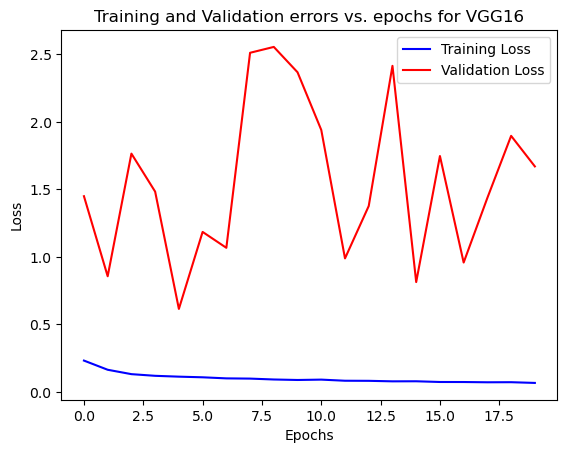

In [54]:
# Plot the training and validation errors vs. epochs.
plt.plot(history_vgg.history['loss'], label='Training Loss', color='blue')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation errors vs. epochs for VGG16')
plt.legend()
plt.show()

In [7]:
model_vgg = load_model('best_model_vgg.h5')

In [ ]:
# for train set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_train_aug:
    preds = model_vgg.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_vgg_train = classification_report(true_test_labels, predicted_labels)  

# for val set
true_test_labels = []
all_predictions = []
for imgs, labels in tf_dataset_val:
    preds = model_vgg.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)
cr_vgg_val = classification_report(true_test_labels, predicted_labels)  

# for test set
true_test_labels = []
all_predictions = []

for imgs, labels in tf_dataset_test:
    preds = model_vgg.predict(imgs)
    all_predictions.append(preds) 
    true_test_labels.extend(labels.numpy())
    
combined_predictions = np.concatenate(all_predictions, axis=0)
predicted_labels = np.argmax(combined_predictions, axis=1)

cr_vgg_test = classification_report(true_test_labels, predicted_labels)         

In [16]:
print(f'For train set of VGG16: \n {cr_vgg_train}')
print(f'For val set of VGG16: \n {cr_vgg_val}')    
print(f'For test set of VGG16: \n {cr_vgg_test}') 

For train set of VGG16: 
               precision    recall  f1-score   support

           0       0.60      0.78      0.68     12235
           1       0.81      0.63      0.71     17444

    accuracy                           0.69     29679
   macro avg       0.70      0.71      0.69     29679
weighted avg       0.72      0.69      0.69     29679

For val set of VGG16: 
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      7654
           1       0.64      0.96      0.76      3632

    accuracy                           0.81     11286
   macro avg       0.80      0.85      0.80     11286
weighted avg       0.87      0.81      0.82     11286

For test set of VGG16: 
               precision    recall  f1-score   support

           0       0.95      0.79      0.86      4418
           1       0.90      0.98      0.94      8405

    accuracy                           0.91     12823
   macro avg       0.93      0.88      0.90     12823

### vi. Compare the results and explain.

In [31]:
# extract info from classification_report manually
import pandas as pd
print('For train data:')
data_train = {
    'CNN+MLP (softmax)': [0,0,0,0.59,1,0.74],
    'CNN+MLP (sigmoid)': [0.59,0.86,0.7,0.86,0.58,0.69],
    'EfficientNetB0 (sigmoid)': [0,0,0,0.59,1,0.74],
    'EfficientNetB0 (softmax)': [0.34,0.27,0.3,0.55,0.63,0.59],
    'ResNet50 (sigmoid)': [0.72,0.03,0.05,0.59,0.99,0.74],
    'VGG16 (sigmoid)': [0.6,0.78,0.68,0.81,0.63,0.71]
}

res_train = pd.DataFrame(data_train, index=['Precision[0]', 'Recall[0]', 'F1 score[0]','Precision[1]', 'Recall[1]', 'F1 score[1]'])
res_train

For train data:


,CNN+MLP (softmax),CNN+MLP (sigmoid),EfficientNetB0 (sigmoid),EfficientNetB0 (softmax),ResNet50 (sigmoid),VGG16 (sigmoid)
Precision[0],0.00,0.59,0.00,0.34,0.72,0.60
Recall[0],0.00,0.86,0.00,0.27,0.03,0.78
F1 score[0],0.00,0.70,0.00,0.30,0.05,0.68
Precision[1],0.59,0.86,0.59,0.55,0.59,0.81
Recall[1],1.00,0.58,1.00,0.63,0.99,0.63
F1 score[1],0.74,0.69,0.74,0.59,0.74,0.71


In [32]:
print('For val data:')
data_val = {
    'CNN+MLP (softmax)': [0,0,0,0.32,1,0.49],
    'CNN+MLP (sigmoid)': [0.93,0.97,0.95,0.92,0.84,0.88],
    'EfficientNetB0 (sigmoid)': [0,0,0,0.32,1,0.49],
    'EfficientNetB0 (softmax)': [0.22,0.05,0.08,0.24,0.65,0.35],
    'ResNet50 (sigmoid)': [0.98,0.61,0.75,0.54,0.97,0.69],
    'VGG16 (sigmoid)': [0.97,0.74,0.84,0.64,0.96,0.76]
}

res_val = pd.DataFrame(data_val, index=['Precision[0]', 'Recall[0]', 'F1 score[0]','Precision[1]', 'Recall[1]', 'F1 score[1]'])
res_val

For val data:


,CNN+MLP (softmax),CNN+MLP (sigmoid),EfficientNetB0 (sigmoid),EfficientNetB0 (softmax),ResNet50 (sigmoid),VGG16 (sigmoid)
Precision[0],0.00,0.93,0.00,0.22,0.98,0.97
Recall[0],0.00,0.97,0.00,0.05,0.61,0.74
F1 score[0],0.00,0.95,0.00,0.08,0.75,0.84
Precision[1],0.32,0.92,0.32,0.24,0.54,0.64
Recall[1],1.00,0.84,1.00,0.65,0.97,0.96
F1 score[1],0.49,0.88,0.49,0.35,0.69,0.76


In [33]:
print('For test data:')
data_test = {
    'CNN+MLP (softmax)': [0,0,0,0.66,1,0.79],
    'CNN+MLP (sigmoid)': [0.61,1,0.76,1,0.67,0.8],
    'EfficientNetB0 (sigmoid)': [0,0,0,0.66,1,0.79],
    'EfficientNetB0 (softmax)': [0.07,0.05,0.06,0.57,0.67,0.62],
    'ResNet50 (sigmoid)': [0.89,0.71,0.79,0.86,0.96,0.91],
    'VGG16 (sigmoid)': [0.95,0.79,0.86,0.9,0.98,0.94]
}

res_test = pd.DataFrame(data_test, index=['Precision[0]', 'Recall[0]', 'F1 score[0]','Precision[1]', 'Recall[1]', 'F1 score[1]'])
res_test

For test data:


,CNN+MLP (softmax),CNN+MLP (sigmoid),EfficientNetB0 (sigmoid),EfficientNetB0 (softmax),ResNet50 (sigmoid),VGG16 (sigmoid)
Precision[0],0.00,0.61,0.00,0.07,0.89,0.95
Recall[0],0.00,1.00,0.00,0.05,0.71,0.79
F1 score[0],0.00,0.76,0.00,0.06,0.79,0.86
Precision[1],0.66,1.00,0.66,0.57,0.86,0.90
Recall[1],1.00,0.67,1.00,0.67,0.96,0.98
F1 score[1],0.79,0.80,0.79,0.62,0.91,0.94


We know that:

From precision,we can get the ratio of correctly predicted positive observations to the total predicted positives (TP/TP+FP).A high precision indicates that when the model predicts a positive result, it is likely to be correct.

From recall, we can get the ratio of correctly predicted positive observations to the total actual positives(TP/TP+FN). A high recall indicates that the model is good at identifying most of the positive instances.

From F1 score, we can get the harmonic mean of precision and recall (2*precision*recall/precision+recall). A high F1 score indicates a good balance between precision and recall.

### Let's compare the results:

1. CNN+MLP using softmax: The model predicts every label to be in class 1, so this is a bad model that needs to be abandoned.

2. CNN+MLP using sigmoid: This seems to be a moderate level model. Precision, recall and F1 score for both classes are not bad.

3. EfficientNetB0 using sigmoid: The model predicts every label to be in class 1, so this is a bad model that needs to be abandoned. 

4. EfficientNetB0 using softmax: The performance of class 0 is not good, while the performance of class 1 is in moderate level.

5. ResNet50 (sigmoid): The results for val and test set are good, but something weired for the predictions of class 0 in train set, recall and F1 score is very low, while precision is fine. So for this model, it might not have learned enough about class 0 during training, leading to lower recall and F1 score.

6. VGG16 (sigmoid): Precision, recall and F1 score are great for bothe classes, which show that this model performs very well.

After dropping CNN+MLP (softmax) and EfficientNetB0 (sigmoid):

### For Class 0:
#### Train Set:
Precision: ResNet50 (sigmoid) with a maximum of 0.72

Recall: CNN+MLP (sigmoid) with a maximum of 0.86

F1-score: CNN+MLP (sigmoid) with a maximum of 0.7
#### Validation Set:
Precision: ResNet50(sigmoid) with a maximum of 0.98, while VGG16 (sigmoid) has value of 0.97.

Recall: CNN+MLP (sigmoid) with a maximum of 0.97

F1-score: CNN+MLP (sigmoid) with a maximum of 0.95
#### Test Set:
Precision: VGG16 (sigmoid) with a maximum of 0.95

Recall: CNN+MLP (sigmoid) with a maximum of 1

F1-score: VGG16 (sigmoid) with a maximum of 0.86

### For Class 1:
#### Train Set:
Precision: CNN+MLP (sigmoid) with a maximum of 0.86

Recall: ResNet50 (sigmoid) with a maximum of 0.99

F1-score: ResNet50 (sigmoid) with a maximum of 0.74
#### Validation Set:
Precision: CNN+MLP (sigmoid) with a maximum of 0.92

Recall: ResNet50(sigmoid) with a maximum of 0.97, while VGG16 (sigmoid) has value of 0.96.

F1-score: CNN+MLP (sigmoid) with a maximum of 0.88

#### Test Set:
Precision: CNN+MLP (sigmoid) with a maximum of 1

Recall: VGG166(sigmoid) with a maximum of 0.98, while ResNet50 (sigmoid) has value of 0.96.

F1-score: VGG166(sigmoid) with a maximum of 0.94, while ResNet50 (sigmoid) has value of 0.91.


### Conclusion and future work

When looking at the graphs of training and validation errors vs. epochs, for models except CNN+MLP using softmax, the validation error is fluctuating for each epoch, this issue may reflects that these models are overfitting. Maybe I need to use a much lower learning rate for smoother convergence, or try to use larger batch size.

In general, it seems that ResNet50 and VGG16 have the best performance among all the models I trained. Besides, CNN+MLP using sigmoid is also worth to consider. 

Class 0 Performance consistently shows lower precision, recall, and F1-score compared to class 1, indicating issues with the model's ability to recognize this class and difficulty in learning representations for class 0.